In [190]:
import cv2 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [191]:
def rgb_equalized(image):
    channels = cv2.split(image)
    eq_channels = []
    for ch, color in zip(channels, ['B', 'G', 'R']):
        eq_channels.append(cv2.equalizeHist(ch))
    eq_image = cv2.merge(eq_channels)
    return eq_image

In [192]:
def remove_background(raw_image):
    plt.imshow(raw_image)
    image = cv2.resize(raw_image, None, fx=700/max(raw_image.shape), fy=700/max(raw_image.shape))
    image_blur = cv2.GaussianBlur(image, (7, 7), 0);
    image_equalised = rgb_equalized(image_blur)
    edges = cv2.Canny(image_equalised, 120, 300)
    plt.imshow(edges)
    plt.show()

    left = np.where(np.cumsum(np.max(edges/255, axis=0))==1)[0][0]
    right = np.argmax(np.cumsum(np.max(edges/255, axis=0)))
    top = np.where(np.cumsum(np.max(edges/255, axis=1))==1)[0][0]
    bottom = np.argmax(np.cumsum(np.max(edges/255, axis=1)))
    #print(top, bottom, right, left)

    img = image.copy()
    mask = np.zeros(img.shape[:2],np.uint8)   # img.shape[:2] = (413, 620)
    bgdModel = np.zeros((1,65),np.float64)
    fgdModel = np.zeros((1,65),np.float64)
    width = right-left
    height = bottom-top
    rect = (int(0.97*left), int(0.97*top), int(1.03*width), int(1.03*height))
    cv2.grabCut(img,mask,rect,bgdModel,fgdModel,3,cv2.GC_INIT_WITH_RECT)
    mask2 = np.where((mask==2)|(mask==0),0,1).astype('uint8')

    # adding additional dimension for rgb to the mask, by default it gets 1
    # multiply it with input image to get the segmented image
    img_cut = img*mask2[:,:,np.newaxis]
    return img_cut

In [193]:
def overlay_mask(mask, image):
    rgb_mask = cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB)
    img = cv2.addWeighted(rgb_mask, 0.5, image, 0.5, 0)
    return image

def find_contours(image):
    image = image.copy()
    _, contours, hierarchy = cv2.findContours(image, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    contour_sizes = [(cv2.contourArea(contour), contour) for contour in contours]
    #biggest_contour = max(contour_sizes, key=lambda x:x[0])[1]
    mask = np.zeros(image.shape, np.uint8)
    cv2.drawContours(mask, contours, -1, 255, -1)
    return contours, mask

def draw_contour(image, contours):
    image_with_rectangle = image.copy()
    for contour in contours:
        x,y,w,h = cv2.boundingRect(contour)
        cv2.rectangle(image_with_rectangle,(x,y),(x+w,y+h),(0,255,0),2)
        #cv2.ellipse(image_with_ellipse, ellipse, green, 2, cv2.LINE_AA)
    return image_with_rectangle

In [194]:
def get_masks(image_blur_hsv):
    min_red = np.array([0, 100, 80])
    max_red = np.array([10, 256, 256])
    mask1 = cv2.inRange(image_blur_hsv, min_red, max_red)
    min_red_2 = np.array([170, 100, 80])
    max_red_2 = np.array([180, 256, 256])
    mask2 = cv2.inRange(image_blur_hsv, min_red_2, max_red_2)
    mask_red = mask1 + mask2
    
    ## Add Gray mask here!!
    min_g1 = np.array([0, 5, 30])
    max_g1 = np.array([15, 22, 120])
    mask_1 = cv2.inRange(image_blur_hsv, min_g1, max_g1)
    min_g2 = np.array([165, 5, 30])
    max_g2 = np.array([180, 22, 120])
    mask_2 = cv2.inRange(image_blur_hsv, min_g2, max_g2)
    mask_gray = mask_1 + mask_2
    
    ## Check this again
    lower_green = np.array([35,80,0])
    upper_green = np.array([75,155,155])
    mask_green = cv2.inRange(image_blur_hsv, lower_green, upper_green)

    lower_purple = np.array([135,70,70])
    upper_purple = np.array([145,255,255])
    mask_purple = cv2.inRange(image_blur_hsv, lower_purple, upper_purple)

    lower_blue = np.array([105,70,70])
    upper_blue = np.array([130,255,255])
    mask_blue = cv2.inRange(image_blur_hsv, lower_blue, upper_blue)

    lower_brown = np.array([10,60,60])
    upper_brown = np.array([20,180,180])
    mask_brown = cv2.inRange(image_blur_hsv, lower_brown, upper_brown)
    
    ## This too!! Someone please help!
    lower_cyan = np.array([85,60,20])
    upper_cyan = np.array([95,255,255])
    mask_cyan = cv2.inRange(image_blur_hsv, lower_cyan, upper_cyan)

    lower_yellow = np.array([25,50,50])
    upper_yellow = np.array([32,255,255])
    mask_yellow = cv2.inRange(image_blur_hsv, lower_yellow, upper_yellow)
    
    return [mask_red, mask_green, mask_blue, mask_purple, mask_cyan, mask_yellow, mask_brown, mask_gray]

In [199]:
def detect_objects(processed_image):
    image_blur = cv2.GaussianBlur(processed_image, (7, 7), 0)
    image_blur_hsv = cv2.cvtColor(image_blur, cv2.COLOR_RGB2HSV)
    masks = get_masks(image_blur_hsv)
    for mask in masks:
        image = processed_image.copy()
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (15, 15))
        mask_closed = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
        mask_clean = cv2.morphologyEx(mask_closed, cv2.MORPH_OPEN, kernel)
        objects, mask = find_contours(mask_clean)
        overlay = overlay_mask(mask_clean, image)
        bounded = draw_contour(overlay, objects)
        plt.imshow(bounded)
        plt.show()

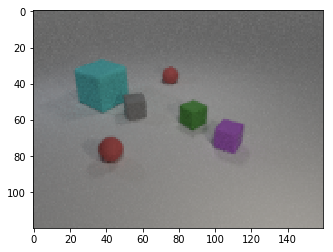

In [234]:
image = cv2.cvtColor(cv2.imread("training_data/images/CLEVR_new_000219.png"), cv2.COLOR_BGR2RGB)
plt.imshow(image)

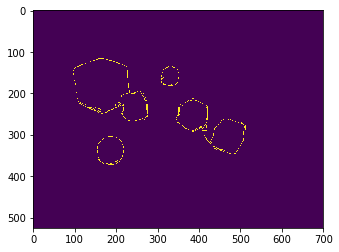

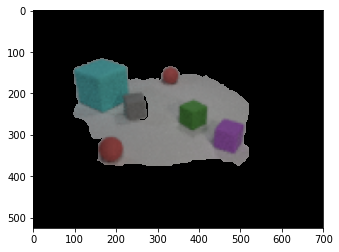

In [235]:
processed_image = remove_background(image)
plt.imshow(processed_image)

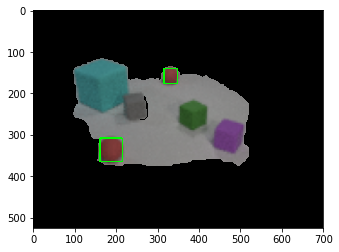

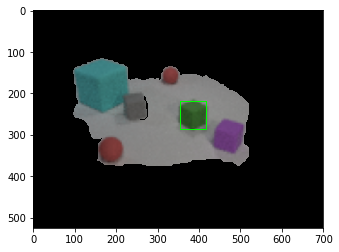

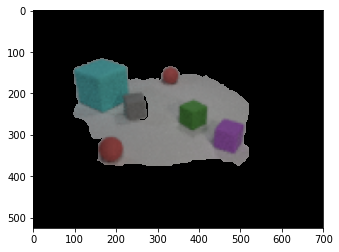

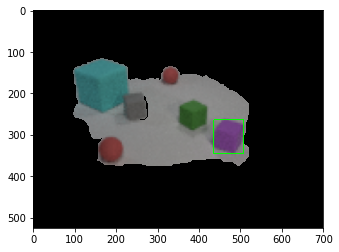

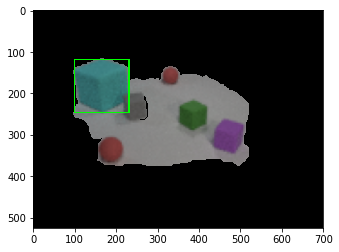

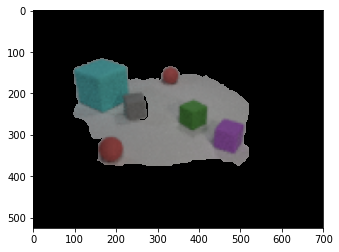

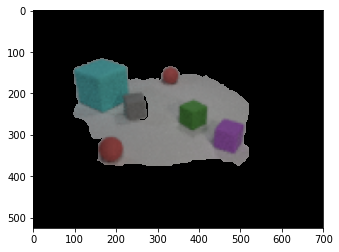

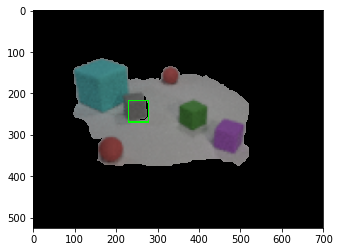

In [236]:
detect_objects(processed_image)